## TO-DO/BUGS/Considerations

### BUGS

- When introducing the ECG as feature, the prediction gives nan values. Need to try to implement a single feature LSTM autoencoder on the ECG and see if the behaviour is different

### TO-DO

- It's possible to remove the logic of removing sample into norm functions, since (verify again) the idx_remove is always empty i.e. no sample produces a RuntimeWarning

### Considerations

- L'errore di ricostruzxoine è minore usando la normalizzazione con la media
- In normalizing functions when substituting neg values with the mean of the single sample, the mean itself can be negative. I tried to use the mean of the entire feature set, but this leads to very bad performances in both training and prediction. Let's stick with substituting neg values with the sample mean.

## Environment setup

In [1]:
import vitaldb
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed


from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer



2023-03-18 20:25:26.799881: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data load

### API data load

In [2]:

def load_healthy_API(type='a',n_cases=None):
    caseids_all = vitaldb.find_cases(['ECG_II','ART_DBP','ART_SBP','BT','HR','RR']) # find ids of patient with this parameters
    # Load dataset
    df = pd.read_csv('https://api.vitaldb.net/cases')
    df = df[df['asa'] < 3]

    caseids_unhealthy = df['caseid'].to_numpy() 
    caseids = [el for el in caseids_all if el in caseids_unhealthy]

    if(n_cases is None):
        n_cases = len(caseids)

    ecg = []
    dbp = []
    sbp = []
    bt  = []
    hr  = []
    rr  = []

    if(type in ('a','n','w')):

        if(type in ('a','n')):

            # load all the patients data 
            for i in range(0,n_cases): # Select only five patient for testing purpose; then len(caseids)
                try:
                    vals = vitaldb.load_case(caseids[i], ['ART_DBP','ART_SBP','BT','HR','RR'])
                    dbp.append(vals[:,0])
                    sbp.append(vals[:,1])
                    bt.append(vals[:,2])
                    hr.append(vals[:,3])
                    rr.append(vals[:,4])

                    # extract non-null values
                    dbp[i] = dbp[i][~np.isnan(dbp[i])]  
                    sbp[i] = sbp[i][~np.isnan(sbp[i])] 
                    bt[i] = bt[i][~np.isnan(bt[i])]
                    hr[i] = hr[i][~np.isnan(hr[i])] 
                    rr[i] = rr[i][~np.isnan(rr[i])]

                except Exception as e: 
                    print('\n=================\n')
                    print('INDEX: '+str(i))
                    print('ERROR: '+str(type(e)))
                    print('\n=================\n')
                    pass

        if(type in ('a','w')):
            for i in range(0,n_cases):
                #vals = vitaldb.load_case(caseids[i], ['ECG_II'], 0.01) #parameter 0.01 for a 'zoomed' ecg
                vals = vitaldb.load_case(caseids[i], ['ECG_II'])
                ecg.append(vals[:,0])
    
    return ecg,dbp,sbp,bt,hr,rr



In [3]:

def load_ills_API(type='a',n_cases=None):
    caseids_all = vitaldb.find_cases(['ECG_II','ART_DBP','ART_SBP','BT','HR','RR']) # find ids of patient with this parameters
    # Load dataset
    df = pd.read_csv('https://api.vitaldb.net/cases')
    df = df[df['asa'] > 3]

    caseids_unhealthy = df['caseid'].to_numpy() 
    caseids = [el for el in caseids_all if el in caseids_unhealthy]

    if(n_cases is None):
        n_cases = len(caseids)

    ecg = []
    dbp = []
    sbp = []
    bt  = []
    hr  = []
    rr  = []

    if(type in ('a','n','w')):

        if(type in ('a','n')):

            # load all the patients data 
            for i in range(0,n_cases): # Select only five patient for testing purpose; then len(caseids)
                try:
                    vals = vitaldb.load_case(caseids[i], ['ART_DBP','ART_SBP','BT','HR','RR'])
                    dbp.append(vals[:,0])
                    sbp.append(vals[:,1])
                    bt.append(vals[:,2])
                    hr.append(vals[:,3])
                    rr.append(vals[:,4])

                    # extract non-null values
                    dbp[i] = dbp[i][~np.isnan(dbp[i])]  
                    sbp[i] = sbp[i][~np.isnan(sbp[i])] 
                    bt[i] = bt[i][~np.isnan(bt[i])]
                    hr[i] = hr[i][~np.isnan(hr[i])] 
                    rr[i] = rr[i][~np.isnan(rr[i])]

                except Exception as e: 
                    print('\n=================\n')
                    print('INDEX: '+str(i))
                    print('ERROR: '+str(type(e)))
                    print('\n=================\n')
                    pass

        if(type in ('a','w')):
            for i in range(0,n_cases):
                #vals = vitaldb.load_case(caseids[i], ['ECG_II'], 0.01) #parameter 0.01 for a 'zoomed' ecg
                vals = vitaldb.load_case(caseids[i], ['ECG_II'])
                ecg.append(vals[:,0])
    
    return ecg,dbp,sbp,bt,hr,rr



### Disk data load

In [4]:
def load_from_disk(path):
    ecg = []
    dbp = []
    sbp = []
    bt  = []
    hr  = []
    rr  = []

# save the data into a file since loading all the 2k caseids requires at least 1h
    filepath = os.path.join(path,'numeric_data.vitaldb')
    ecgpath = os.path.join(path,'ecg_data.vitaldb')
    #ecgpath = '/Volumes/Windows/SIIA/ecg_data.vitaldb'

    with open(ecgpath, 'rb') as f:
        (ecg) = pickle.load(f)
    with open(filepath, 'rb') as f:
        (dbp,sbp,bt,hr,rr) = pickle.load(f)
    
    return ecg,dbp,sbp,bt,hr,rr

In [5]:
def save_to_disk(path,ecg,dbp,sbp,bt,hr,rr):
# save the data into a file since loading all the 2k caseids requires at least 1h

    with open(os.path.join(path,'numeric_data.vitaldb'), 'wb') as f:
        pickle.dump((dbp,sbp,bt,hr,rr), f)

    with open(os.path.join(path,'ecg_data.vitaldb'), 'wb') as f:
        pickle.dump(ecg, f)



## save the data into a file since loading all the 2k caseids requires at least 1h
#filepath = '/Users/Roberto/projects/siiaproject-vitanomaly/data.vitaldb'
#ecgpath = '/Volumes/Windows/SIIA/ecg_data.vitaldb'
#ecgpath = '/Users/Roberto/projects/siiaproject-vitanomaly/ecg_data.vitaldb'


### Visualize

In [6]:
def plot_data(ecg,dbp,sbp,bt,hr,rr,val = None):
    
    if(val == None or not isinstance(val,int)):
        val = np.argmin([len(el) for el in sbp])
        print(val)
    
    plt.figure(figsize=(20,10))
    plt.subplot(611)
    plt.title("ECG")
    plt.plot(ecg[val], color='yellow')
    plt.subplots_adjust(hspace=1.)
    plt.subplot(612)
    plt.title("DBP")
    plt.plot(dbp[val], color='b')
    plt.subplots_adjust(hspace=1.)
    plt.subplot(613)
    plt.title("SBP")
    plt.plot(sbp[val][:], color='r')

    plt.subplot(614)
    plt.title("Body temperature")
    plt.plot(bt[val][:], color='orange')

    plt.subplot(615)
    plt.title("Heart rate")
    plt.plot(hr[val][:], color='r')

    plt.subplot(616)
    plt.title("Respiratory rate")
    plt.plot(rr[val][:], color='g')
    plt.show()

## Preprocessing

In [7]:
def remove_empty(ecg,dbp,sbp,bt,hr,rr):
# remove empty elements

    try:
        for i in range(0,len(ecg) - len([el for el in ecg if len(el) == 0])):
            if(len(ecg[i])==0):
                ecg.pop(i)
    except:
        pass

    try:
        for i in range(0,len(dbp) - len([el for el in dbp if len(el) == 0])):
            if(len(dbp[i])==0):
                dbp.pop(i)
    except:
        pass

    try:
        for i in range(0,len(sbp) - len([el for el in sbp if len(el) == 0])):
            if(len(sbp[i])==0):
                sbp.pop(i)
    except:
        pass

    try:
        for i in range(0,len(bt) - len([el for el in bt if len(el) == 0])):
            if(len(bt[i])==0):
                bt.pop(i)
    except:
        pass

    try:
        for i in range(0,len(hr) - len([el for el in hr if len(el) == 0])):
            if(len(hr[i])==0):
                hr.pop(i)
    except:
        pass

    try:
        for i in range(0,len(rr) - len([el for el in rr if len(el) == 0])):
            if(len(rr[i])==0):
                rr.pop(i)
    except:
        pass

    try:
        for i in range(0,len(ecg) - len([el for el in ecg if len(el) == 0])):
            if(len(ecg[i])==0):
                ecg.pop(i)
    except:
        pass

    return ecg,dbp,sbp,bt,hr,rr



In [8]:
def minmax_norm(ecg,dbp,sbp,bt,hr,rr):


    flat_list_ecg = np.asarray([item for sublist in ecg for item in sublist],dtype='float64')
    flat_list_dbp = np.asarray([item for sublist in dbp for item in sublist],dtype='float64')
    flat_list_sbp = np.asarray([item for sublist in sbp for item in sublist],dtype='float64')
    flat_list_hr = np.asarray([item for sublist in hr for item in sublist],dtype='float64')
    flat_list_bt = np.asarray([item for sublist in bt  for item in sublist],dtype='float64')
    flat_list_rr = np.asarray([item for sublist in rr for item in sublist],dtype='float64')
    #print({'dbp':len(flat_list_dbp),'sbp':len(flat_list_sbp),'hr':len(flat_list_hr),'bt':len(flat_list_bt),'rr':len(flat_list_rr)})


    ecg_min,ecg_max = np.min(flat_list_ecg),np.max(flat_list_ecg)
    dbp_min,dbp_max = np.min(flat_list_dbp),np.max(flat_list_dbp)
    sbp_min,sbp_max = np.min(flat_list_sbp),np.max(flat_list_sbp)
    bt_min,bt_max = np.min(flat_list_bt),np.max(flat_list_bt)
    hr_min,hr_max = np.min(flat_list_hr),np.max(flat_list_hr)
    rr_min,rr_max = np.min(flat_list_rr),np.max(flat_list_rr)
    
    old_settings = np.seterr(all='raise')
    idx_remove = []

    for i in range(0,len(ecg)): 
        try:
            ecg[i] = (ecg[i] - ecg_min)/(ecg_max - ecg_min) 
            ecg[i][np.argwhere(ecg[i]<0)] = np.mean(ecg[i])
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove.append(i)

    for idx in idx_remove: 
        ecg.pop(idx)

    idx_remove = []
    for i in range(0,len(dbp)): 
        try:
            dbp[i] = (dbp[i] - dbp_min)/(dbp_max - dbp_min) 
            dbp[i][np.argwhere(dbp[i]<0)] = np.mean(dbp[i])
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove.append(i)

    for idx in idx_remove: 
        dbp.pop(idx)

    idx_remove = []  
    for i in range(0,len(sbp)): 
        try:
            sbp[i] = (sbp[i] - sbp_min)/(sbp_max - sbp_min) 
            sbp[i][np.argwhere(sbp[i]<0)] = np.mean(sbp[i])
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove.append(i)

    for idx in idx_remove: 
        sbp.pop(idx)



    idx_remove = []
    for i in range(0,len(bt)): 
        try:
            bt[i] = (bt[i] - bt_min)/(bt_max - bt_min) 
            bt[i][np.argwhere(bt[i]<0)] = np.mean(bt[i])
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove.append(i)

    for idx in idx_remove: 
        bt.pop(idx)



    idx_remove = []
    for i in range(0,len(hr)): 
        try:
            hr[i] = (hr[i] - hr_min)/(hr_max - hr_min) 
            hr[i][np.argwhere(hr[i]<0)] = np.mean(hr[i])
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove.append(i)

    for idx in idx_remove: 
        hr.pop(idx)


    idx_remove = []
    for i in range(0,len(rr)): 
        try:
            rr[i] = (rr[i] - rr_min)/(rr_max - rr_min) 
            rr[i][np.argwhere(rr[i]<0)] = np.mean(rr[i])
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove.append(i)

    for idx in idx_remove: 
        rr.pop(idx)


    # Back to default settings for errors
    np.seterr(**old_settings)

    

    return ecg,dbp,sbp,bt,hr,rr


In [9]:
def mean_norm(ecg,dbp,sbp,bt,hr,rr):


    flat_list_ecg = np.asarray([item for sublist in ecg for item in sublist],dtype='float64')
    flat_list_dbp = np.asarray([item for sublist in dbp for item in sublist],dtype='float64')
    flat_list_sbp = np.asarray([item for sublist in sbp for item in sublist],dtype='float64')
    flat_list_hr = np.asarray([item for sublist in hr for item in sublist],dtype='float64')
    flat_list_bt = np.asarray([item for sublist in bt  for item in sublist],dtype='float64')
    flat_list_rr = np.asarray([item for sublist in rr for item in sublist],dtype='float64')
    #print({'dbp':len(flat_list_dbp),'sbp':len(flat_list_sbp),'hr':len(flat_list_hr),'bt':len(flat_list_bt),'rr':len(flat_list_rr)})
    print({'dbp':len(dbp),'sbp':len(sbp),'hr':len(hr),'bt':len(bt),'rr':len(rr)})


    ecg_mean,ecg_std = np.mean(flat_list_ecg),np.std(flat_list_ecg)
    dbp_mean,dbp_std = np.mean(flat_list_dbp),np.std(flat_list_dbp)
    sbp_mean,sbp_std = np.mean(flat_list_sbp),np.std(flat_list_sbp)
    bt_mean,bt_std = np.mean(flat_list_bt),np.std(flat_list_bt)
    hr_mean,hr_std = np.mean(flat_list_hr),np.std(flat_list_hr)
    rr_mean,rr_std = np.mean(flat_list_rr),np.std(flat_list_rr)

    print('Mean values for features:\n')
    print({'ecg_mean':ecg_mean,'dbp':dbp_mean,'sbp':sbp_mean,'hr':hr_mean,'bt':bt_mean,'rr':rr_mean})

    # Consider runtime warnings such as Divide by zero as Exceptions to throw
    old_settings = np.seterr(all='raise')
    idx_remove = []
    


    for i in range(0,len(ecg)): 
        try:
            ecg[i] = (ecg[i] - ecg_mean)/(ecg_std) 
            ecg[i][np.argwhere(ecg[i]<=0)] = np.mean(ecg[i])
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove.append(i)

    for idx in idx_remove: 
        ecg.pop(idx)
    
    idx_remove = []
    for i in range(0,len(dbp)): 
        try:
            dbp[i] = (dbp[i] - dbp_mean)/(dbp_std) 
            dbp[i][np.argwhere(dbp[i]<=0)] = np.mean(dbp[i])
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove.append(i)

    for idx in idx_remove: 
        dbp.pop(idx)

    idx_remove = []  
    for i in range(0,len(sbp)): 
        try:
            sbp[i] = (sbp[i] - sbp_mean)/(sbp_std) 
            sbp[i][np.argwhere(sbp[i] <= 0)] = np.mean(sbp[i])
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove.append(i)

    for idx in idx_remove: 
        sbp.pop(idx)

        

    idx_remove = []
    for i in range(0,len(bt)): 
        try:
            bt[i] = (bt[i] - bt_mean)/(bt_std) 
            bt[i][np.argwhere(bt[i]<=0)] = np.mean(bt[i])
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove.append(i)

    for idx in idx_remove: 
        bt.pop(idx)



    idx_remove = []
    for i in range(0,len(hr)): 
        try:
            hr[i] = (hr[i] - hr_mean)/(hr_std) 
            hr[i][np.argwhere(hr[i]<=0)] = np.mean(hr[i])
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove.append(i)

    for idx in idx_remove: 
        hr.pop(idx)


    idx_remove = []
    for i in range(0,len(rr)): 
        try:
            rr[i] = (rr[i] - rr_mean)/(rr_std) 
            rr[i][np.argwhere(rr[i]<=0)] = np.mean(rr[i])
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove.append(i)

    for idx in idx_remove: 
        rr.pop(idx)


    # Back to default settings for errors
    np.seterr(**old_settings)

    

    return ecg,dbp,sbp,bt,hr,rr



In [10]:
def get_preprocessed_data(path, norm = 'mean'):
    ecg,dbp,sbp,bt,hr,rr = load_from_disk(path=path)
    ecg,dbp,sbp,bt,hr,rr = remove_empty(ecg,dbp,sbp,bt,hr,rr)
    if(norm == 'mean'):
        ecg,dbp,sbp,bt,hr,rr = mean_norm(ecg,dbp,sbp,bt,hr,rr )
    elif(norm == 'minmax'): 
        ecg,dbp,sbp,bt,hr,rr = minmax_norm(ecg,dbp,sbp,bt,hr,rr )

    return ecg,dbp,sbp,bt,hr,rr 

In [28]:
norm = 'mean'
func_norm = norm + '_norm'
normalize = globals()[func_norm] # normalize is called later for test data normalization

ecg,dbp,sbp,bt,hr,rr = get_preprocessed_data('/Users/Roberto/projects/AnomalyDetection/data/processed',norm = norm)

{'dbp': 2874, 'sbp': 2877, 'hr': 2877, 'bt': 2876, 'rr': 2877}
Mean values for features:

{'ecg_mean': 0.03230831506824195, 'dbp': 59.96132529688496, 'sbp': 111.08083396743335, 'hr': 72.52115204116221, 'bt': 35.30464862834198, 'rr': 15.78349493322607}


46


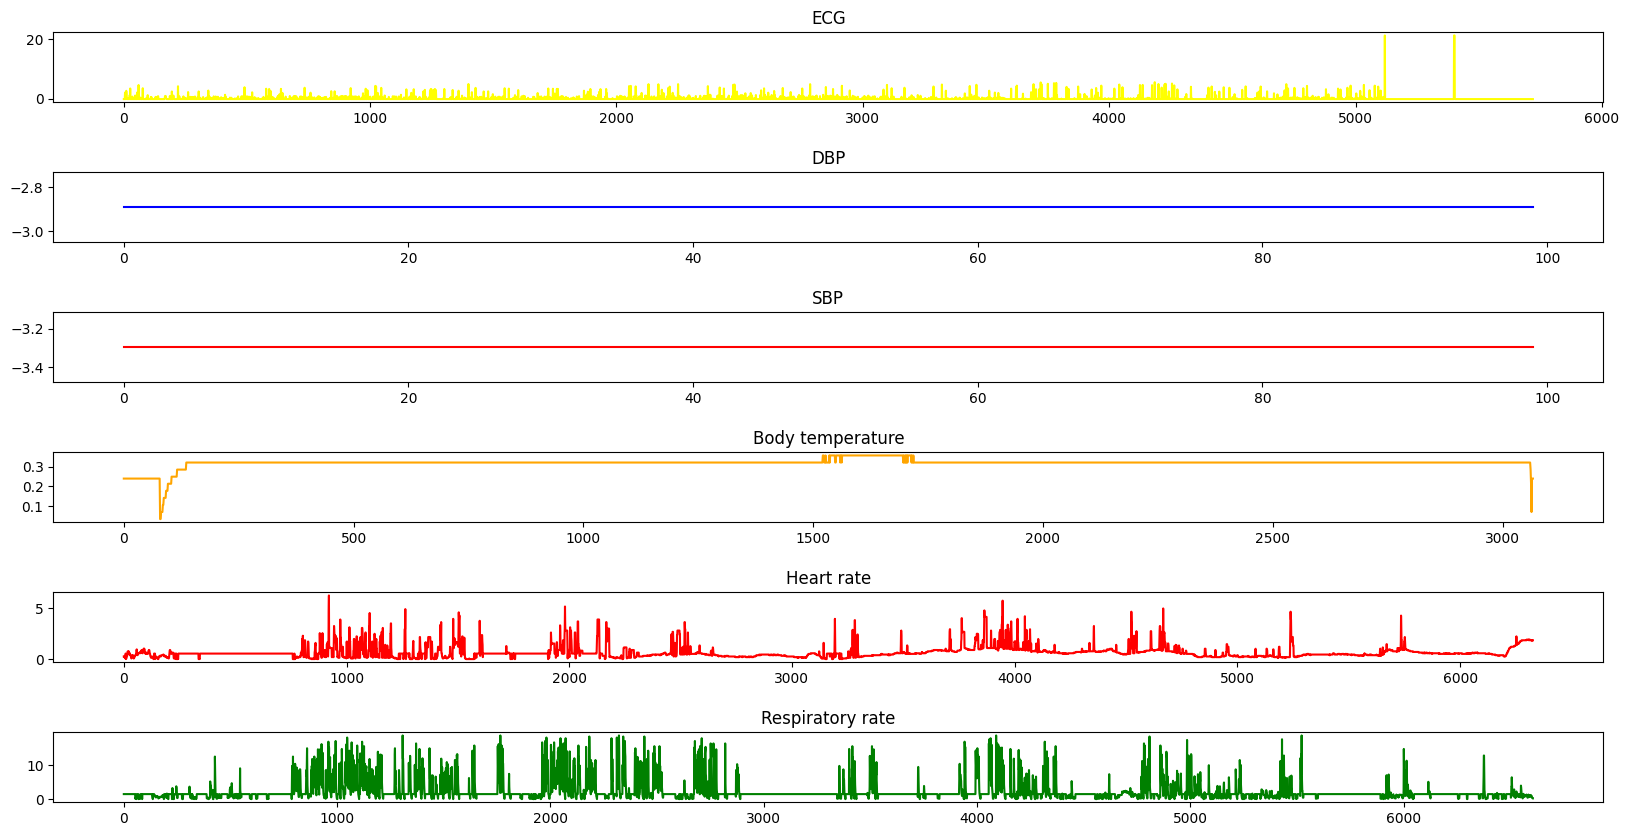

In [29]:
plot_data(ecg,dbp,sbp,bt,hr,rr)

# Autoencoder

## LSTM Autoencoder


### Multivariate

In [30]:
TIME_STEP = 6000 # 6000 is the mean length of the dbp time series

flat_list_ecg = np.asarray([item for sublist in ecg for item in sublist],dtype='float64')
flat_list_dbp = np.asarray([item for sublist in dbp for item in sublist],dtype='float64')
flat_list_sbp = np.asarray([item for sublist in sbp for item in sublist],dtype='float64')
flat_list_hr = np.asarray([item for sublist in hr for item in sublist],dtype='float64')
flat_list_bt = np.asarray([item for sublist in bt  for item in sublist],dtype='float64')
flat_list_rr = np.asarray([item for sublist in rr for item in sublist],dtype='float64')
print({'ecg': len(flat_list_ecg),'dbp':len(flat_list_dbp),'sbp':len(flat_list_sbp),'hr':len(flat_list_hr),'bt':len(flat_list_bt),'rr':len(flat_list_rr)})

{'ecg': 19464031, 'dbp': 17738184, 'sbp': 17756137, 'hr': 18369986, 'bt': 15624782, 'rr': 18123465}


In [31]:
X_ecg = []
X_dbp = []
X_sbp = []
X_bt  = []
X_hr  = []
X_rr  = []

for seq in range(0,len(flat_list_ecg), TIME_STEP):
    X_ecg.append(flat_list_ecg[seq:seq+TIME_STEP])

for seq in range(0,len(flat_list_dbp), TIME_STEP):
    X_dbp.append(flat_list_dbp[seq:seq+TIME_STEP])

for seq in range(0,len(flat_list_sbp), TIME_STEP):
    X_sbp.append(flat_list_sbp[seq:seq+TIME_STEP])

for seq in range(0,len(flat_list_bt), TIME_STEP):
    X_bt.append(flat_list_bt[seq:seq+TIME_STEP])

for seq in range(0,len(flat_list_hr), TIME_STEP):
    X_hr.append(flat_list_hr[seq:seq+TIME_STEP])

for seq in range(0,len(flat_list_rr), TIME_STEP):
    X_rr.append(flat_list_rr[seq:seq+TIME_STEP])


X_ecg = np.asarray(X_ecg,dtype=object)
X_dbp = np.asarray(X_dbp,dtype=object)
X_sbp = np.asarray(X_sbp,dtype=object)
X_bt = np.asarray(X_bt,dtype=object)
X_hr = np.asarray(X_hr,dtype=object)
X_rr = np.asarray(X_rr,dtype=object)

X_ecg= pad_sequences(X_ecg, TIME_STEP,padding='post',value = np.mean(flat_list_ecg),dtype='float64')
X_dbp = pad_sequences(X_dbp, TIME_STEP,padding='post',value = np.mean(flat_list_dbp),dtype='float64')
X_sbp = pad_sequences(X_sbp, TIME_STEP,padding='post',value = np.mean(flat_list_sbp),dtype='float64')
X_rr = pad_sequences(X_rr, TIME_STEP,padding='post',value = np.mean(flat_list_rr),dtype='float64')
X_hr = pad_sequences(X_hr, TIME_STEP,padding='post',value = np.mean(flat_list_hr),dtype='float64')
X_bt = pad_sequences(X_bt, TIME_STEP,padding='post',value = np.mean(flat_list_bt),dtype='float64')

X_ecg = np.asarray(np.expand_dims(X_ecg,axis=2))
X_dbp = np.asarray(np.expand_dims(X_dbp,axis=2))
X_sbp = np.asarray(np.expand_dims(X_sbp,axis=2))
X_bt = np.asarray(np.expand_dims(X_bt,axis=2))
X_hr = np.asarray(np.expand_dims(X_hr,axis=2))
X_rr = np.asarray(np.expand_dims(X_rr,axis=2))

In [32]:
# Truncate all the values to the min length of the training istances
min_len = np.min([X_dbp.shape[0],X_sbp.shape[0],X_bt.shape[0],X_hr.shape[0],X_rr.shape[0]])

#The remaining values need to be stored for testing
X_ecg = X_ecg[:min_len,:]
X_dbp = X_dbp[:min_len,:]
X_sbp = X_sbp[:min_len,:]
X_bt = X_bt[:min_len,:]
X_hr = X_hr[:min_len,:]
X_rr = X_rr[:min_len,:]

Y = np.concatenate([X_dbp, X_sbp, X_bt, X_hr, X_rr],axis=2)
X_train = Y[:50,...] # Select the first N instances
print(X_train.shape)

(50, 6000, 5)


In [33]:
batch_size, seq_len, n_features = X_train.shape

In [34]:
model = Sequential()
model.add(LSTM(64, input_shape=(seq_len, n_features),return_sequences=True))
model.add(Dropout(rate=0.1))
model.add(LSTM(32,return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(rate=0.1))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 6000, 64)          17920     
                                                                 
 dropout_2 (Dropout)         (None, 6000, 64)          0         
                                                                 
 lstm_4 (LSTM)               (None, 6000, 32)          12416     
                                                                 
 lstm_5 (LSTM)               (None, 6000, 64)          24832     
                                                                 
 dropout_3 (Dropout)         (None, 6000, 64)          0         
                                                                 
 time_distributed_1 (TimeDis  (None, 6000, 5)          325       
 tributed)                                                       
                                                      

In [35]:
history = model.fit(X_train, X_train, epochs=5,shuffle=True,verbose=1)

Epoch 1/5
2/2 [==============================] - 23s 8s/step - loss: 0.3791
Epoch 2/5
2/2 [==============================] - 18s 8s/step - loss: 0.3454
Epoch 3/5
2/2 [==============================] - 17s 8s/step - loss: 0.3114
Epoch 4/5
2/2 [==============================] - 17s 8s/step - loss: 0.2715
Epoch 5/5
2/2 [==============================] - 18s 8s/step - loss: 0.2275


#### Predict

In [36]:
#hecg,hdbp,hsbp,hbt,hhr,hrr = load_ills_API(n_cases=5)
hecg,hdbp,hsbp,hbt,hhr,hrr = load_healthy_API(n_cases=5)
hecg,hdbp,hsbp,hbt,hhr,hrr = remove_empty(hecg,hdbp,hsbp,hbt,hhr,hrr)
hecg,hdbp,hsbp,hbt,hhr,hrr = normalize(hecg,hdbp,hsbp,hbt,hhr,hrr) # normalize the test instance with the same approach of train ones

{'dbp': 5, 'sbp': 5, 'hr': 5, 'bt': 5, 'rr': 5}
Mean values for features:

{'ecg_mean': nan, 'dbp': 54.28144770791362, 'sbp': 105.65811331424734, 'hr': 73.42930479130318, 'bt': 34.17347314930525, 'rr': 13.297622348537363}


In [37]:
flat_list_hecg = np.asarray([item for sublist in hecg for item in sublist],dtype='float64')
flat_list_hdbp = np.asarray([item for sublist in hdbp for item in sublist],dtype='float64')
flat_list_hsbp = np.asarray([item for sublist in hsbp for item in sublist],dtype='float64')
flat_list_hbt = np.asarray([item for sublist in hbt for item in sublist],dtype='float64')
flat_list_hhr = np.asarray([item for sublist in hhr for item in sublist],dtype='float64')
flat_list_hrr = np.asarray([item for sublist in hrr for item in sublist],dtype='float64')

In [38]:
# It's possible to change the time step to the mean of the mean lenghts of the features
TIME_STEP = 6000 # 6000 is the mean length of the dbp time series 

X_ecg = []
X_dbp = []
X_sbp = []
X_bt = []
X_hr = []
X_rr = []

for seq in range(0,len(flat_list_hecg), TIME_STEP):
    X_ecg.append(flat_list_hecg[seq:seq+TIME_STEP])

for seq in range(0,len(flat_list_hdbp), TIME_STEP):
    X_dbp.append(flat_list_hdbp[seq:seq+TIME_STEP])

for seq in range(0,len(flat_list_hsbp), TIME_STEP):
    X_sbp.append(flat_list_hsbp[seq:seq+TIME_STEP])

for seq in range(0,len(flat_list_hbt), TIME_STEP):
    X_bt.append(flat_list_hbt[seq:seq+TIME_STEP])

for seq in range(0,len(flat_list_hhr), TIME_STEP):
    X_hr.append(flat_list_hhr[seq:seq+TIME_STEP])

for seq in range(0,len(flat_list_hrr), TIME_STEP):
    X_rr.append(flat_list_hrr[seq:seq+TIME_STEP])

X_ecg = np.asarray(X_ecg,dtype=object)
X_dbp = np.asarray(X_dbp,dtype=object)
X_sbp = np.asarray(X_sbp,dtype=object)
X_bt = np.asarray(X_bt,dtype=object)
X_hr = np.asarray(X_hr,dtype=object)
X_rr = np.asarray(X_rr,dtype=object)


X_ecg = pad_sequences(X_ecg, TIME_STEP,padding='post',value = np.mean(flat_list_hecg),dtype='float64')
X_dbp = pad_sequences(X_dbp, TIME_STEP,padding='post',value = np.mean(flat_list_hdbp),dtype='float64')
X_sbp = pad_sequences(X_sbp, TIME_STEP,padding='post',value = np.mean(flat_list_hsbp),dtype='float64')
X_bt = pad_sequences(X_bt, TIME_STEP,padding='post',value = np.mean(flat_list_hbt),dtype='float64')
X_hr = pad_sequences(X_hr, TIME_STEP,padding='post',value = np.mean(flat_list_hhr),dtype='float64')
X_rr = pad_sequences(X_rr, TIME_STEP,padding='post',value = np.mean(flat_list_hrr),dtype='float64')


X_ecg = np.asarray(np.expand_dims(X_ecg,axis=2))
X_dbp = np.asarray(np.expand_dims(X_dbp,axis=2))
X_sbp = np.asarray(np.expand_dims(X_sbp,axis=2))
X_bt = np.asarray(np.expand_dims(X_bt,axis=2))
X_hr = np.asarray(np.expand_dims(X_hr,axis=2))
X_rr = np.asarray(np.expand_dims(X_rr,axis=2))

In [39]:
min_len = np.min([X_dbp.shape[0],X_sbp.shape[0],X_bt.shape[0],X_hr.shape[0],X_rr.shape[0]])

X_ecg = X_ecg[:min_len,:]
X_dbp = X_dbp[:min_len,:]
X_sbp = X_sbp[:min_len,:]
X_bt = X_bt[:min_len,:]
X_hr = X_hr[:min_len,:]
X_rr = X_rr[:min_len,:]

Y = np.concatenate([X_dbp, X_sbp, X_bt, X_hr, X_rr],axis=2)
X_test = Y[:] # Select the first n instances
print(X_test.shape)

(4, 6000, 5)


In [40]:
res = model.predict(X_test)

1/1 [==============================] - 2s 2s/step


In [41]:
n_feature = 1
abs(np.linalg.norm(res[...,n_feature]) - np.linalg.norm(X_test[...,n_feature],2))

29.661150230240168

In [50]:
p = 1 # test instance

# Print the reconstruction error for all the features of a given test instance
print('=======================================')
print('\tTest instance ' + str(p))
print('======================================='+'\n')
tot = 0
for i in range(0,5):
    re = np.round(abs(np.linalg.norm(res[p,:,i]) - np.linalg.norm(X_test[p,:,i],2)),3)
    tot = tot + re
    print('Reconstrucion error on feature ' + str(i) + ': ' + \
          str(re)+'\n')
print('Mean reconstruction error: ' + str(np.round(tot/5,3)))


	Test instance 1

Reconstrucion error on feature 0: 12.007

Reconstrucion error on feature 1: 6.586

Reconstrucion error on feature 2: 2.955

Reconstrucion error on feature 3: 5.058

Reconstrucion error on feature 4: 58.549

Mean reconstruction error: 17.031


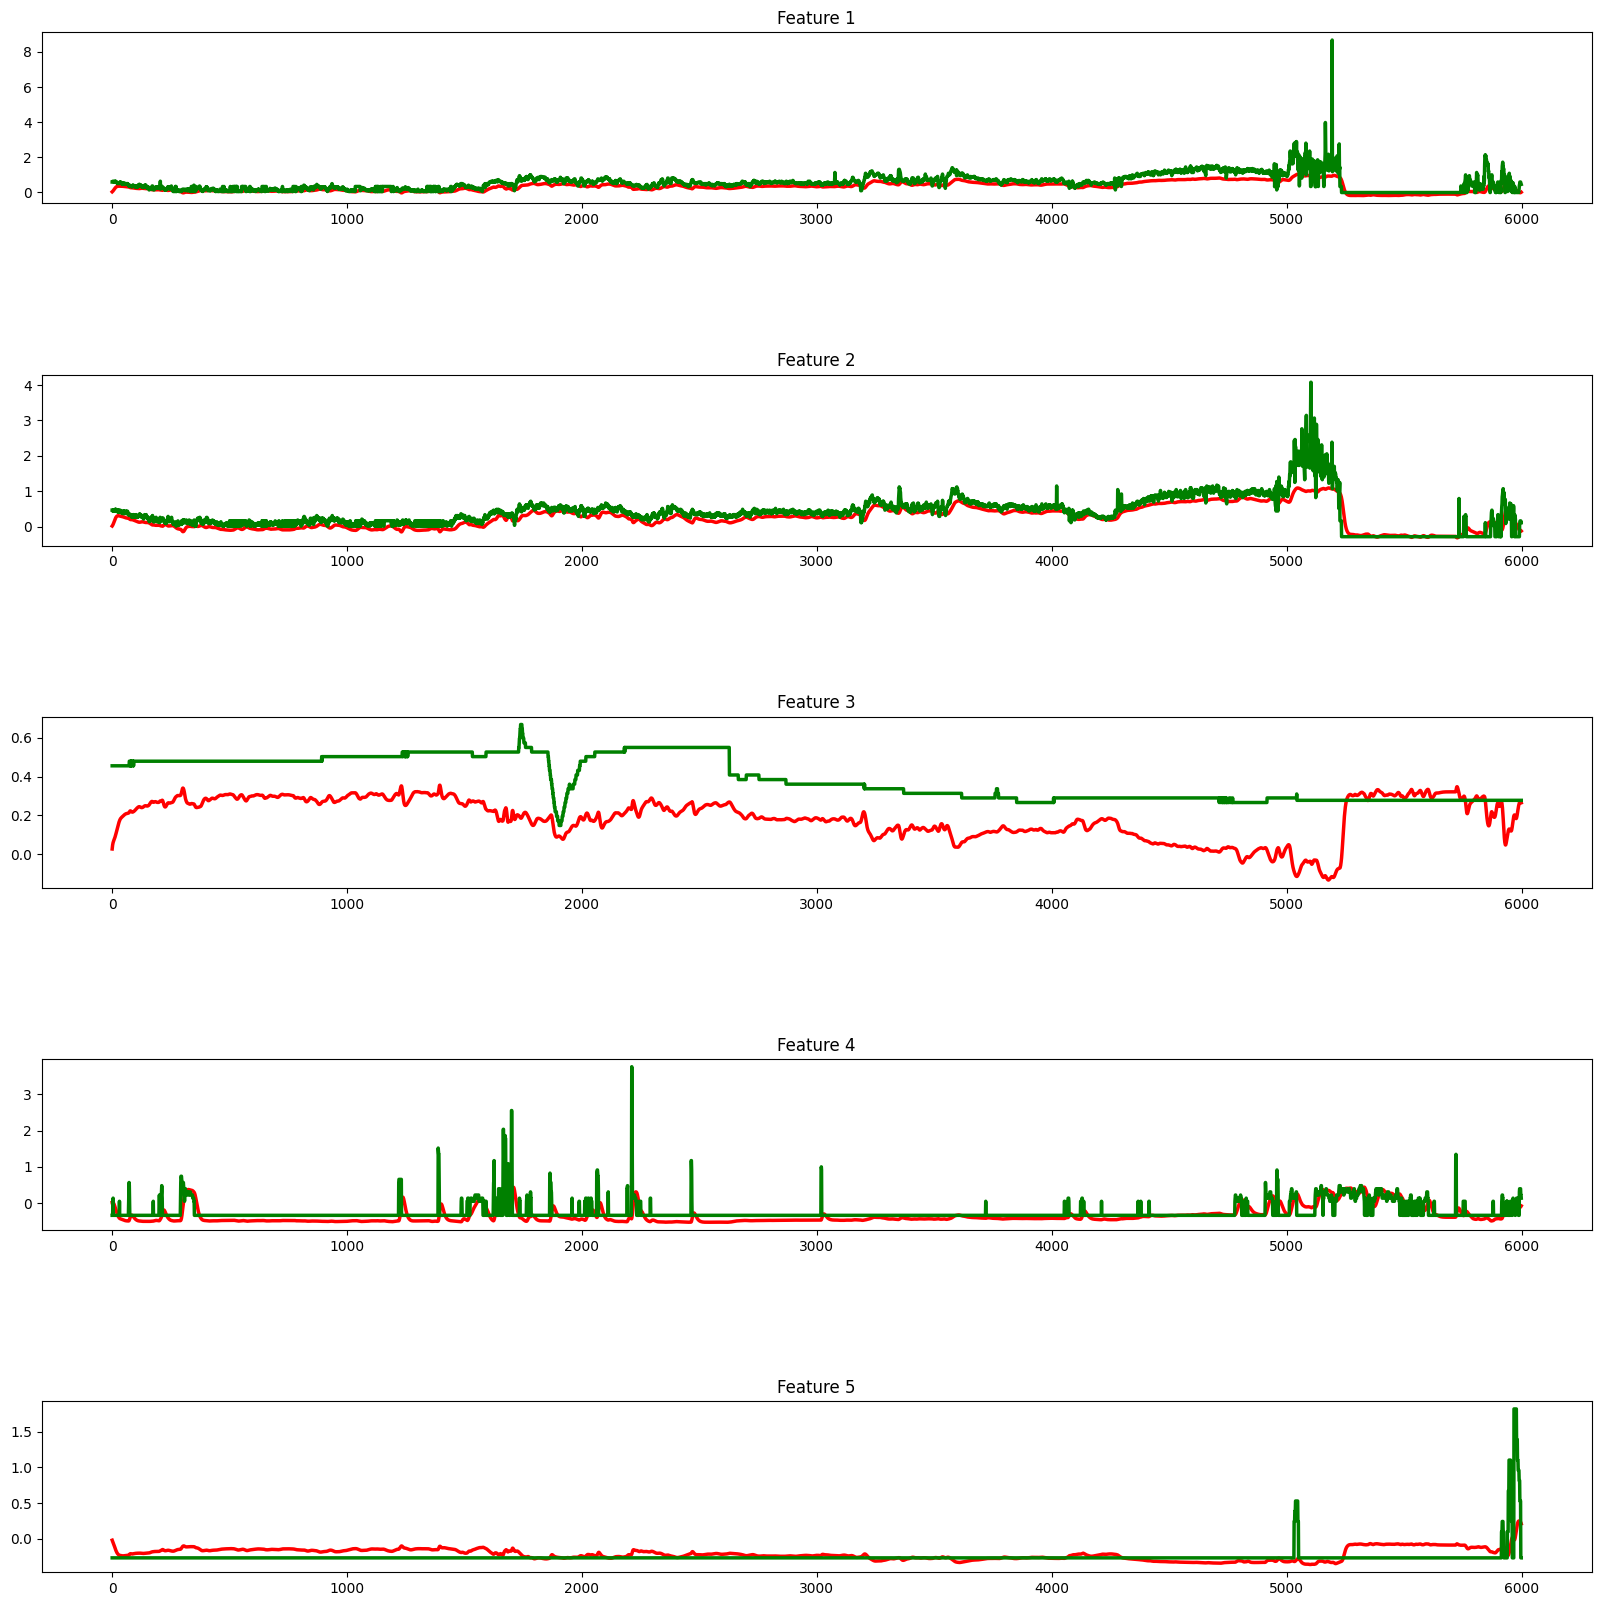

In [43]:
plt.figure(figsize=(20,20))
for i in range(0,5):
    s = '51'+str(i+1)
    plt.subplot(int(s))
    plt.subplots_adjust(hspace=1.)
    plt.title('Feature ' + str(i+1))
    plt.plot(res[p,:,i],'-r',X_test[p,:,i],'-g', linewidth=2.5)

plt.show()

In [44]:
# Plot all the feature data

#plt.figure(figsize=(20,10))
#plt.subplot(211)
#plt.plot(res[...,1])
#plt.subplot(212)
#plt.plot(X_test[...,1])
#plt.show()